# The Inverted Pendulum on a Cart Problem

## Introduction

In this project, we are designing a controller that will balance a pendulum upright. This is exactly like trying to balance an upright pencil on your palm by moving your hand around. In this problem, a mass is attached to the end of a rigid, massless rod. This rod is then pinned to a cart and allowed to rotate freely about one axis. The cart has four wheels all of which roll without slipping on a horizontal surface. Torque can be applied to each wheel, and this allows to cart to traverse side to side. This action will be used to balance the pendulum upright. To solve this problem, we are taking an approach called "model-based control". This means that our controller design will be based on a model of the dynamics of the system. The first step, then, is to use the Lagrangian mechanics formulation to derive the equations of motion.

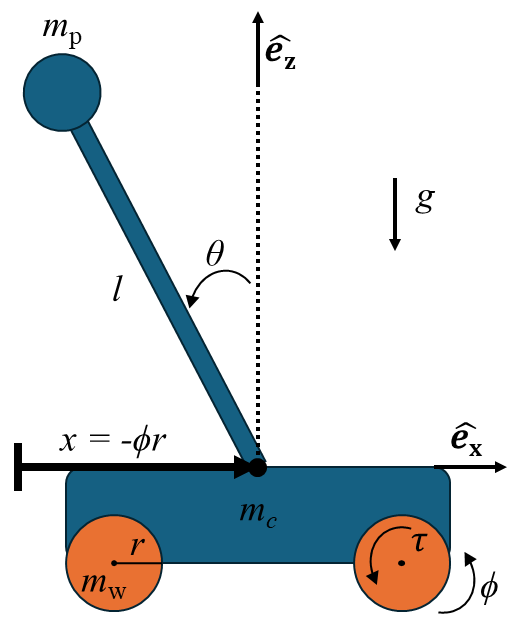

This system is an example of an [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum#:~:text=An%20inverted%20pendulum%20is%20a,additional%20help%20will%20fall%20over.), a classic control example. This is because of the combination of its simple, yet interesting, dynamics. The system itself consists of little more than a hinge and a rod (and in this case wheels); however, it has both a stable equilibrium point (the pedulum balanced directly downward with gravity) and a unstable equilibrium point (the pedulum balanced directly upward against gravity). Further, whereas the actual system dynamics are nonlinear, the behavior of the pendulum near either of these equilibrium points is reasonable well captured by a linear approximation. This phenomenon is called the [small angle approximation](https://en.wikipedia.org/wiki/Small-angle_approximation).

Due to its unstable nature, linearity near equilibrium, and ease of simulation or integration into hardware, the inverted pendulum is often used as a benchmark for testing and improving control systems.

## The Process

To design a model-based controller, we will take 6 steps:
1. Determine the equations of motion of the system
2. Place the equations of motion in standard form
3. Linearize the standard form equations
4. Select a gain matrix that stablizes the system
5. Build a controller with our gain matrix
6. Simulate the system

## 1. System Dynamics and Equations of Motion

Let's derive a dynamic model of the cart. There are two ***generalized coordinates*** for our system: the pendulum angle, $\theta$, and the wheel angle, $\phi$. Because we assume that all the wheels are rolling without slipping, each wheel has the same angle. Further, the $x$ coordinate of the cart can be expressed in terms of the wheel angle and the radius of the wheels, $r$. Lastly, the input to the system is some torque, $\tau$, that is applied equally to all the wheels.

The first step in the Lagrangian mechanics approach to deriving the equations of motion of a system is to calculate the kinetic and potential energies of the system with respect to the generalized coordinates and their derivatives. We can do this using the Python package Sympy.

In [ ]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols, lambdify
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the ***parameters*** of the system. These parameters are defined in the .urdf file that describes the cart system.

In [ ]:
# Parameters of the system
mp = 4.0      # Mass of the pendulum mass in kg
mc = 23.5     # Mass of the chassis in kg
mw = 1.8      # Mass of each wheel in kg
Izz = 0.01214 # Moment of inertial of each wheel about its rotational axis in kg-m^2
l = 1.0       # Length of the pendulum rod in m
r = 0.125     # Radius of each wheel in m
g = 9.81      # Acceleration due to gravity in m/s^2

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [ ]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

Next we calculate the energies of the system. We can start by getting the energies of the pendulum mass. We can do this by:
1. Defining its position in terms of the generalized coordinates
2. Take the derivate of the position with respect to time to get the velocity
3. Calculate the kinetic energy from the velocity
4. Calculate the potential energy by observation

In [ ]:
# Get the position of the mass in terms of phi and theta
pos = Matrix([-r*phi(t) - l*sin(theta(t)), 0.0, l*cos(theta(t))])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

Because the connecting rod of the pendulum has no mass nor mass moment of inertia, we can move on the the energy of the cart. The cart does not change height, so we can just set its potential energy to 0. This means all we have to do is calculate the kinetic energy.

In [ ]:
# Get the position of the cart in terms of phi and theta
pos = Matrix([-phi(t)*r, 0.0, 0.0])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of the cart from the velocity
cart_KE = 0.5 * mc * (vel.T @ vel)[0,0]

Finally, we move on to the wheels. For the same reason as the cart, we set their potential energy to 0 also. This means we just need to calculate thier kinetic and rotational energy. Also, while calculating the position, we will ignore the constant offsets that each of the four wheels have (length and width of the wheel base). We can do this because constants disappear during differentiation.

In [ ]:
# Get the position of the wheels in terms of phi and theta
pos = Matrix([-phi(t)*r, 0.0, 0.0])

# Take the derivative of the position with respect to time
vel = diff(pos,t)

# Get the kinetic energy of all four wheels from the velocity
wheel_KE = 4.0 * (0.5 * mw * (vel.T @ vel)[0,0])

# Get the rotational kinetic energy of all four wheels
wheel_RE = 4.0*(Izz*diff(phi(t),t)**2)

Now we calculate the ***lagrangian*** of the system, $L$, via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

In [ ]:
# Get the lagrangian
L = (mass_KE + cart_KE + wheel_KE + wheel_RE) - mass_PE
L = simplify(L)
print("System Lagrangian:")
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

Finally, the equations of motion of the system are defined via the nonconservative ***Euler-Lagrange equations***:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q_j}} \right) - \frac{\partial L}{\partial q_j} = F_j$$

Where $q_j$ is the $j$th generalized coordinate of the system and $F_j$ is the applied (external) input acting on the $j$th generalized coordinate. For this system, then, the Euler-Lagrange equations take the form:

$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=4\tau$$

Solving these equations:

In [ ]:
# Get the left hand side of the first equation of motion
f1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

# Get the left hand side of the second equation of motion
f2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - 4.0*tau(t)

Currently, the equations of motion are in the form:
$$
f_1 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$
$$
f_2 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$

This form of equations of motion is not very helpful to us right now, so next we will place them in the form:
$$
\frac{\partial^{2} \theta}{\partial t^{2}} = f_{\theta} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$
$$
\frac{\partial^{2} \phi}{\partial t^{2}} = f_{\phi} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$

In [ ]:
# Solve the first two equations of motion for the second order derivatives
soln = solve([f1, f2], Derivative(theta(t), (t, 2)), Derivative(phi(t), (t, 2)))
soln = simplify(soln)
f_theta = soln[Derivative(theta(t), (t, 2))]
f_phi = soln[Derivative(phi(t), (t, 2))]

Let's now combine these two equations into a single vector and replace the functions of time with symbols (this will make the linearization steps easier).

In [ ]:
# Build the equations of motion vector
f = Matrix([f_theta, f_phi])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({Derivative(theta(t), t) : v1,
            Derivative(phi(t), t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(thetadot, phidot, theta, phi, tau) = symbols('thetadot, phidot, theta, phi, tau')
f = f.subs({v1 : thetadot,
            v2 : phidot,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

Now we have $f$ as our system model such that:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau)
$$

In [ ]:
print('f(theta_dot, phi_dot, theta, phi, tau)=')
N(f, 3) # This rounds floating point number to 3 places and then prints to the screen

## 2. Standard Form

For model-based controls, a ***standard form*** of equations of motion is typically used:
$$
\dot{\mathbf{m}} = f(\mathbf{m}, \mathbf{n}),
$$

where $\mathbf{m}$ is the ***nonlinear state vector*** and $\mathbf{n}$ is the ***nonlinear input vector***.

There are two major differences between our current system and a system in standard form:
1. All the equations in our system are *second order*. Standard form requires all equations to be *first order*.
2. There are dervative arguments in our current system, $f$. Standard form requires that all arguments to $f$ are *zeroth order*. 

To fix problem 1, we need to replace both our *second order* differential equations with two *first order* differential equations. To do this, we can define two new variables: $\omega_{\theta}$ and $\omega_{\phi}$. We define these new variables via the differential equations:
$$
\dot{\theta} = \omega_{\theta} 
$$
$$
\dot{\phi} = \omega_{\phi}.
$$

Now we expand our current system by appending these two new differential equations to the end:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix}.
$$

Next, by taking a derivative of our two new differential equations, we find
$$
\ddot{\theta} = \dot{\omega}_{\theta}
$$
$$
\ddot{\phi} = \dot{\omega}_{\phi}.
$$

Therefore, we can replace the second order differential equations with first order differential equations via a change of variables:
$$
\begin{bmatrix}
\dot{\omega}_{\theta} \\
\dot{\omega}_{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix},
$$

This new system is a *first order* system of differential equations, which is what we wanted. To replicate this in code, we can do the following two steps:

In [ ]:
# Create our two new variables...
(omega_theta, omega_phi) = sym.symbols('omega_theta, omega_phi')

# and append them to the bottom of the system.
f = sym.Matrix([f[0], f[1], omega_theta, omega_phi])

Now we need to fix problem 2: there are dervative arguments in our current system. Standard form requires that all arguments to the system of differential equations are *zeroth order*. The good news is that we already have all the tools we need to correct this problem. To begin, note that the derivative arguments are in the functions
$$
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau)
$$
and 
$$
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau).
$$

Recall that we have already created the variables $\omega_{\theta}$ and $\omega_{\phi}$ which are defined as
$$
\dot{\theta} = \omega_{\theta} 
$$
$$
\dot{\phi} = \omega_{\phi}.
$$
Therefore, to ensure all arguments to the system are *zeroth order*, we can simply replace every instance of $\dot{\theta}$ and $\dot{\phi}$ with $\omega_{\theta}$ and $\omega_{\phi}$, respectively. This results in a system with the form:
$$
\begin{bmatrix}
\dot{\omega}_{\theta} \\
\dot{\omega}_{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix}.
$$

Every argument to this system is now *zeroth order*, which is what we wanted. To replicate this in code, we can do the following one step:

In [ ]:
# Make the change of variables
f = f.subs({thetadot : omega_theta, phidot : omega_phi})

If we define the nonlinear state vector like this:
$$
\mathbf{m} = 
\begin{bmatrix}
{\omega}_{\theta} \\
{\omega}_{\phi} \\
{\theta} \\ 
{\phi}
\end{bmatrix},
$$
and the nonlinear input vector like this:
$$
\mathbf{n} = \left[ \tau \right],
$$
then we can rewrite the system we have created like this:
$$
\dot{\mathbf{m}} = f(\mathbf{m},\mathbf{n})
$$
which is standard form.

In [ ]:
print('f(m,n)=')
sym.N(f, 3) # Display f in standard form

## 3. Linearizing the System

Now we want to approximate the nonlinear system dynamics near an equilibrium point by linearizing the system to have the form
$$
\dot{\mathbf{x}} = A\mathbf{x} + B\mathbf{u},
$$
where $\mathbf{x}$ is the ***linear state vector*** and $\mathbf{u}$ is the ***linear input vector***. We call this model ***state space form***. There are three steps we take to convert our current nonlinear, standard form system of equations into state space form:
1. Choose an ***equilibrium point*** towards which the controller will drive the system.
2. Define $\mathbf{x}$ and $\mathbf{u}$.
3. Calculate $A$, also called the ***state matrix***.
4. Calculate $B$, also called the ***input matrix***.

Let's begin by finding an equilibrium point. An equilibrium point is any combination of nonlinear state, $\mathbf{m_{e}}$, and nonlinear input, $\mathbf{n_{e}}$, such that
$$
f(\mathbf{m_{e}}, \mathbf{n_{e}}) = 0.
$$
This is also called a ***stationary point*** because the time derivative of the nonlinear state vector—also called the nonlinear velocity vector—is exactly zero. Remember, we already have $f$, so all we need to do is find a valid $\mathbf{m_{e}}$ and $\mathbf{n_{e}}$. This equilibrium point will be the state that our controller drives the system towards, i.e., if our controller works, as time goes to infinity, the system will go to this equilibrium point. This is called ***stablization***. Accordingly, it would make sense to choose the equilibrium point where the pendulum is balanced upright ($\theta=0$) and the cart is at its starting position ($x=0$). Let's check to see if this is a valid equilibrium point. 

In [ ]:
# Convert symbolic system to a numeric function
f_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], f)

# Check the 0 angle, 0 position equilibrium point
omega_theta_e = 0.0 # To be stationary, the derivative of theta must be 0
omega_phi_e = 0.0   # To be stationary, the derivative of phi must be 0
theta_e = 0.0       # The pendulum balancing upright
phi_e = 0.0         # The cart at the starting position
tau_e = 0.0         # No torque applied to the wheels

# Test if our guess is an equilibrium position
print('f(me,ne)=')
print(f_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e))

Because the output of our equations of motion at the selected nonlinear state vector and nonlinear input vector is 0, we have confirmed our choice is valid equilibrium point. Now we can move on to calculate the $A$ and $B$ matrices.

Recall, our system is currently in standard form:
$$
\dot{\mathbf{m}} = f(\mathbf{m},\mathbf{n}),
$$
and we have just found an equilibrium position such that 
$$
f(\mathbf{m_{e}}, \mathbf{n_{e}}) = 0.
$$

Suppose we Taylor expand our system around the equilibrium position:
$$
f(\mathbf{m}, \mathbf{n}) \approx f(\mathbf{m_{e}}, \mathbf{n_{e}}) + \left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{m} - \mathbf{m_{e}}) + \left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{n} - \mathbf{n_{e}}),
$$
where $\frac{\partial y}{\partial \mathbf{z}}$ represents the jacobian of $y$ with respect to the vector $\mathbf{z}$.

Because $f(\mathbf{m_{e}}, \mathbf{n_{e}})=0$ by design, and because $\dot{\mathbf{m}}=f(\mathbf{m},\mathbf{n})$, the above equation is equivalent to
$$
\dot{\mathbf{m}} \approx \left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{m} - \mathbf{m_{e}}) + \left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{n} - \mathbf{n_{e}}).
$$

Note that, because $\mathbf{m_{e}}$ is a constant,
$$
\dot{\mathbf{m}} = \frac{d}{dt} \left( \mathbf{m} - \mathbf{m_{e}} \right).
$$
Based on this fact, we can rewrite the left hand side of the Taylor expansion as
$$
\frac{d}{dt} \left( \mathbf{m} - \mathbf{m_{e}} \right) \approx \left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{m} - \mathbf{m_{e}}) + \left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}(\mathbf{n} - \mathbf{n_{e}}).
$$

The above equation yields a natural definition for the linear state vector, $\mathbf{x}$, the linear input vector $\mathbf{u}$, the state matrix, $A$, and the input matrix $B$ such that
\begin{align}
\mathbf{x} &= \mathbf{m} - \mathbf{m_{e}}\\
\mathbf{u} &= \mathbf{n} - \mathbf{n_{e}}\\
A &= \left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}\\
B &= \left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}\\
\end{align}

Applying this change of variables, we arrive at the equation
$$
\dot{\mathbf{x}} \approx A\mathbf{x} + B\mathbf{u},
$$
which is state space form.

 Now that we have defined $A$ and $B$, we can calculate them from our standard form equations of motion and chosen equilibrium point. For $A$, this looks like:

In [ ]:
# Define the nonlinear state vector
m = [omega_theta, omega_phi, theta, phi]

# Take the jacobian of f with respect to the nonlinear state vector
A_sym = f.jacobian(m)

# Convert the symbolic jacobian to a numeric representation
A_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], A_sym)

# Evalulate the jacobian of f with respect to the nonlinear state vector at the equilibrium point
A = A_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print A
print('A=')
print(A)

Similarly for $B$:

In [ ]:
# Define the nonlinear input vector
n = [tau]

# Take the jacobian of f with respect to the nonlinear input vector
B_sym = f.jacobian(n)

# Convert the symbolic jacobian to a numeric representation
B_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], B_sym)

# Evalulate the jacobian of f with respect to the nonlinear input vector at the equilibrium point
B = B_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print B
print('B=')
print(B)

Summarizing the linearization process, once the system was placed in standard form we
1. Found the equilbrium point to which the controller will drive the system
2. Defined the linear state vector, $\mathbf{x}$, and linear input vector, $\mathbf{u}$.
3. Defined and calculated the state matrix, $A$.
4. Defined and calculated the input matrix, $B$.

This allows us to *approximate* the nonlinear system dynamics *near the chosen equilibrium point* by converting our nonlinear system,
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau),
$$
to a linear system in state space form:
$$
\dot{\mathbf{x}} \approx A\mathbf{x} + B\mathbf{u}.
$$

## 4. Controller Design

### 4a. Selecting a Control Law 

We now need to select a ***control law***. A control law is defined as an algorithm that determines what inputs are used at a given time. For this project, we will use a control law called ***linear state feedback***. This control law has the form
$$
\mathbf{u} = -K\mathbf{x},
$$
where $K$ is called the ***gain matrix***. Selecting an appropriate gain matrix for a given system is one of the major challenges addressed in control theory.

Applying this control law to our state space model we get
\begin{align}
\dot{\mathbf{x}} &\approx A\mathbf{x} + B\mathbf{u}\\
\dot{\mathbf{x}} &\approx A\mathbf{x} - BK\mathbf{x}\\
\dot{\mathbf{x}} &\approx (A-BK)\mathbf{x}\\
\dot{\mathbf{x}} &\approx F\mathbf{x},
\end{align}
where $F$ is the ***closed loop response matrix***. This equation of motion is called the ***closed loop response***, i.e., how the system will dynamically behave when feedback control is applied to it.

### 4b. Analyzing Closed Loop Response

If the closed loop response was a single differential equation instead of a system of coupled differential equations, that is if $\mathbf{x}$ was a scalar instead of a vector and $F$ was a scalar instead of a matrix, the system would be trivial to solve. The solution to such a first order linear ordinary differential equation is given by
$$
x(t) = x_0 e^{ft},
$$

where $x(t)$ is the scalar version of $\mathbf{x}$, $x_0$ is the initial condition of $x$, $f$ is the scalar version of $F$, and $t$ is time. If we try this same approach for our system, though, we run into some trouble. Whereas we can still easily define $\mathbf{x_0}$ as the initial condition of the linear state vector, we cannot exponentiate matrices. Or can we?

There is a process called ***matrix exponentiation*** that solves this exact problem. This is achieved through exponentiation of the ***Jordan normal form*** of a matrix. In Jordan normal form, an $n\times n$ matrix, $H$, is represented as
$$
H = P^{-1}JP,
$$
where $P$ is an $n\times n$ invertible matrix and $J$ is an $n\times n$ ***Jordan matrix***. A Jordan matrix is a square matrix comprised of block matrices along its diagonal. Each of these block matrices, called ***Jordan blocks***, are themselves square matrices of zeroes everywhere except for the main diagonal and the diagonal just above and to the right of the main diagonal, also called the superdiagonal.

Each Jordan block has the form 
$$
\begin{bmatrix}
    \lambda & 1 & 0 & \cdots & 0 & 0 & 0\\
    0 & \lambda & 1 & \cdots & 0 & 0 & 0 \\
    0 & 0 & \lambda & \cdots & 0 & 0 & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
    0 & 0 & 0 & \cdots & \lambda & 1 & 0\\
    0 & 0 & 0 & \cdots & 0 & \lambda & 1\\
    0 & 0 & 0 & \cdots & 0 & 0 & \lambda
\end{bmatrix}
$$
where $\lambda$ is an eigenvalue of $H$.

To build the full Jordan matrix, at least one Jordan block is built for each unique eigenvalue of $H$ and then inserted along the diagonal of the full Jordan matrix. The algebraic multiplicity of an eigenvalue determines the number of times it appears along the the diagonal of the Jordan matrix and its geometric multiplicity determines the number of Jordan blocks for it in the Jordan matrix. For example, if an eigenvalue had algebraic multiplicity 3 and geometric multiplicity 2, then two Jordan blocks would be used to make the eigenvalue appear 3 times along the diagonal of the Jordan matrix, i.e. a $2\times 2$ Jordan block and a $1 \times 1$ Jordan block would be used.

Whereas it is not necessary to be able to build the Jordan matrix by hand, it is a very important tool for analyzing the closed loop response of a state space system via matrix exponentiation. As it turns out, we can define the exponentiation of a single $m \times m$ Jordan block for eigenvalue $\lambda$ as:
$$
e^{J_it} = e^{\lambda t}
\begin{bmatrix}
    1 & t & \frac{t^2}{2} & \cdots & \frac{t^{m-3}}{(m-3)!} & \frac{t^{m-2}}{(m-2)!} & \frac{t^{m-1}}{(m-1)!}\\
    0 & 1 & t & \cdots & \frac{t^{m-4}}{(m-4)!} & \frac{t^{m-3}}{(m-3)!} & \frac{t^{m-2}}{(m-2)!} \\
    0 & 0 & 1 & \cdots & \frac{t^{m-5}}{(m-5)!} & \frac{t^{m-4}}{(m-4)!} & \frac{t^{m-3}}{(m-3)!} \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots\\
    0 & 0 & 0 & \cdots & 1 & t & \frac{t^2}{2}\\
    0 & 0 & 0 & \cdots & 0 & 1 & t\\
    0 & 0 & 0 & \cdots & 0 & 0 & 1
\end{bmatrix}
$$

Given this, we can also define exponentiation of a full Jordan matrix, $J$, via exponentiation of each of the Jordan blocks comprising it:
$$
e^{Jt} = 
\left[\begin{array}{c|c|c|c|c}
  e^{J_0t} & 0 & \cdots & 0 & 0\\
\hline
  0 & e^{J_1t} & \cdots & 0 & 0\\
\hline
  \vdots & \vdots & \ddots & \vdots & \vdots\\
\hline
  0 & 0 & \cdots & e^{J_{k-2}t} & 0\\
\hline
  0 & 0 & \cdots & 0 & e^{J_{k-1}t}\\
\end{array}\right]
$$

Because we defined $J$ such that $H = P^{-1}JP$, we now have a method to exponentiate our original matrix, $H$:
$$
e^{Ht} = P^{-1}e^{Jt}P.
$$

Returning to our closed loop response,
$$
\dot{\mathbf{x}} \approx F\mathbf{x},
$$
we can use our newfound matrix exponentiation to find the solution to this equation as
$$
\mathbf{x}(t) \approx \mathbf{x_0}e^{Ft} = \mathbf{x_0}P^{-1}e^{Jt}P.
$$

Remember, the goal of the controller is to drive the system to some equilibrium state, $\mathbf{m_{e}}$. Given the definition of the linear state vector, this is analogous to saying the controller is attempting to drive $\mathbf{x}$ to 0. For our controller to achieve this, we want the right hand side of this equation to go to 0 and $t \rightarrow \inf$. 

Looking at the definition of Jordan matrix exponentiation, we notice that every single time dependent term on the right hand side of the equation is premultiplied by some exponential function, $e^{\lambda t}$, where $\lambda$ is an eigenvalue of $F$. Because exponential functions grow faster than polynomial functions (which are also present in the Jordan matrix exponentiation), for the right hand side of our equation to go to 0, the exponential functions must go to 0. This occurs when the real part of the exponent goes to $-\inf$ as $t \rightarrow \inf$. 

From this we can conclude that, for the controller to drive the system to the desired equilibrium value, the real part of all eigenvalues of $F$ must be negative. When this condition is met, we call the closed loop response ***asymptotically stable***. Note that because our linear equations of motion, i.e., the state space model, are only valid near the chosen equilibrium point, proof of asymptotic stability via eigenvalue analysis of the closed loop response matrix is also only valid near the chosen equilibrium point. 

### 4c. Selecting Control Gains via Ackermann's Method

Reviewing,
1. We have a system of equations that approximate the dynamic response of the cart and pendulum around an equilibrium point. This system of equations is in state space form:
$$\dot{\mathbf{x}} \approx A\mathbf{x} + B\mathbf{u},$$
where $\mathbf{x}$ is the linear state vector defined as
$$\mathbf{x} = \mathbf{m} - \mathbf{m_e} = \begin{bmatrix}{\omega}_{\theta} \\ {\omega}_{\phi} \\ {\theta} \\ {\phi}\end{bmatrix}-\begin{bmatrix}0 \\ 0 \\ 0 \\ 0\end{bmatrix}=\begin{bmatrix}{\omega}_{\theta} \\ {\omega}_{\phi} \\ {\theta} \\ {\phi}\end{bmatrix},$$
$\mathbf{u}$ is the linear input vector defined as
$$\mathbf{u} = \mathbf{n} - \mathbf{n_e} = \begin{bmatrix}\tau\end{bmatrix}-\begin{bmatrix}0\end{bmatrix}=\begin{bmatrix}\tau\end{bmatrix},$$
$A$ is the state matrix defined as
$$A=\left.\frac{\partial f}{\partial \mathbf{m}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}},$$
and $B$ is the input matrix defined as
$$B=\left.\frac{\partial f}{\partial \mathbf{n}}\right|_{\mathbf{m_{e}}, \mathbf{n_{e}}}.$$

2. We have a control law that defines our linear input vector as a function of the linear state vector:
$$\mathbf{u} = -K\mathbf{x},$$
where $K$ is called the gain matrix. This selected control law is called feedback control.

3. We know that, in the case of feedback control, the closed loop response matrix, $F$, is given by
$$F=A-BK.$$

4. We know that for the system to be asymptotically stable near the equilibrium point, i.e., for $x(t) \rightarrow 0$ as $t \rightarrow \inf$, the real parts of the eigenvalues of the closed loop response matrix must be negative.

So how do we select as set of control gains that make sure the real parts of the eigenvalues of the closed loop response matrix are negative? Because our system only has a single input, we can "place its poles" using a method called ***Ackermann's Method***. "Placing poles" is another way of saying choosing a gain matrix that enforces a selected set of closed loop response matrix eigenvalues.

Consider a state space system $$\dot{\mathbf{x}} \approx A\mathbf{x} + B\mathbf{u}.$$
To begin let's define a new parameter called the ***controllability matrix***, $\mathcal{C}$, such that
$$\mathcal{C}=\begin{bmatrix}B&AB&A^2B&\ldots&A^{n-1}B\end{bmatrix},$$
where $n$ is the number of states in the state space system, i.e., the length of the linear state vector, $\mathbf{x}$.

Next, we select a set of $n$ eigenvalues that we would like the closed loop response matrix to have and determine the characteristic polynomial associated with these eigenvalues. For example, suppose for some system with $n$ states we select $\lambda_1$, ..., $\lambda_n$ as our target eigenvalues. The associated characteristic polynomial, $\Delta$, is 
$$
\Delta(s)=(s-\lambda_1)(s-\lambda_2)...(s-\lambda_n).
$$

Finally, we calculate the gain matrix, $K$, via the ***Ackermann Formula***:
$$
K=[0,0,\ldots,0,1]\mathcal{C}^{-1}\Delta(A),
$$
where 
$$
\Delta(A) = (A-\lambda_1I)(A-\lambda_2I)...(A-\lambda_nI),
$$
and the row vector has length $n$. Note that for all ***controllable state space systems***, the controllability matrix, $\mathcal{C}$, is guaranteed to be invertible.

A controllable system is defined as any system that satisfies the following condition: for all possible pairings of arbitrary initial states, $\mathbf{x_0}$, and terminal states, $\mathbf{x_f}$, there exists a control sequence, $\mathbf{u}(t)$, that drives the system from $\mathbf{x_0}$ to $\mathbf{x_f}$.

Let's try applying Ackermann's method to our system. Because our current system has 4 states, its controllability matrix is defined as
$$\mathcal{C}=\begin{bmatrix}B&AB&A^2B&A^3B\end{bmatrix}.$$
To calculate $\mathcal{C}$ in code, we can use `numpy`'s `hstack` function:

In [ ]:
# Calculate the controllability matrix
ctrb = np.hstack((B, A@B, A@A@B, A@A@A@B))
print("Controllability matrix:")
print(ctrb)

Because there are four states, we need to define four desired eigenvalues. Suppose we want each eigenvalue to be $-2$ (this guarantees asymptotic stability as per our previous closed loop response analysis). Then
$$
\Delta(A) = (A+2I)(A+2I)(A+2I)(A+2I)=(A+2I)^4.
$$
To implement this in code, we can use `numpy`'s `matrix_power` function:

In [ ]:
delta_A = np.linalg.matrix_power(A+2*np.eye(4), 4)

Finally, we can apply Ackermann's formula:
$$K=\left[0,0,0,1\right]\mathcal{C}^{-1}\Delta(A).$$
Implementing in code:

In [ ]:
K = [[0,0,0,1]]@np.linalg.inv(ctrb)@delta_A
print("Gain Matrix:")
print(K)

Let's double check our code worked as expected. To do this, we double check that the eigenvalues our the closed loop response matrix match our desired values of $\left\{-2,-2,-2,-2\right\}$. We can do this with `numpy`'s `eig` function:

In [ ]:
F = A-B@K
eigen_vectors = np.linalg.eig(F)[0]
print('Eigenvalues:')
print(eigen_vectors)

Because `numpy`'s `eig` function is a numerial approximation, there is some floating point error in these terms. Within reasonable rounding, however, we find that, indeed, our selected gain matrix enforces the desired eigenvalues of the closed loop response matrix.

Given the real parts of all the eigenvalues of the closed loop response matrix are now negative, we conclude that our selected gain matrix, $K$, results in a closed loop response that is asymptotically stable.

### 4d. Implementing the Controller

The next step is to test our control law and selected gains in simulation. The provided simulation function expects us to implement a controller function that takes as argument the nonlinear state of the system, $\mathbf{m}$, and return the torque applied to each wheel as a scalar. Implementing this in code:

In [ ]:
def controller(state):
    """
    The controller function. Given some state information, it calculates a torque to apply to each wheel that
    (hopefully) balances the pendulum upright.

    Parameters
    ----------
    state : dictionary of floats with the following keys
        angle : float
            The angle of the pendulum in radians
        angular_rate : float
            The angular rate of the pendulum in radians / second
        wheel : float
            The mean rotation angle of the wheels in radians
        wheel_rate : float
            The mean angular rate of the wheels in radians / second

    Returns
    -------
    torque : float
        The torque to apply to each wheel
    """
    m_e = np.array([0, 0, 0, 0]) # The equilibrium nonlinear state vector
    n_e = np.array([0])          # The equilibrium nonlinear input vector

    # Build the nonlinear state vector
    m = np.array([state['angular_rate'], state['wheel_rate'], state['angle'], state['wheel']])

    # Build the linear state vector
    x = m - m_e

    # Apply the feedback control law with our selected gain matrix to get the linear input vector
    u = K@x

    # Convert the linear input vector into the nonlinear input vector
    n = u + n_e

    # Return the nonlinear torque as a scalar
    torque = n[0]
    return torque

## 5. Running a Simulation

The backend for the simulation has already been made for you. The backend will handle building the simulation environment, running and visualizing the simulation, applying your controller's inputs, and tracking relevant data. Let's import this backend now. It is a function named `run` that is stored in a Python script named `pendulum_cart.py`. 

In [ ]:
# Import the project's backend.
from pendulum_cart import run

Now we are ready to run the simulation and collect data. To do this, we simply call the `run` function as pass as arguments the initial angle of the pendulum and the controller function we just built. In this case, let's set the initial angle to 10 degrees. The simulation will automatically run, apply our controller, and return some data collected during simulation. The returned data is a dictionary with the values:

`data['time']` : list of n floats

    The time, in seconds, at which each data point is collected
    
`data['angle']` : list of n floats

    The angle of the pendulum, in radians, at each of the n data
    collection points.
    
`data['angular_rate']` : list of n floats

    The angular rate of the pendulum, in radians per second, at
    each of the n data collection points.
    
`data['wheel']` : list of n floats

    The mean angle of the wheels, in radians, at each of the n data
    collection points.
    
`data['wheel_rate']`: list of n floats

    The mean angular rate of the wheels, in radians per second,
    at each of the n data collection points.
    
`data['torque']` : list of n floats

    The torque applied to the wheels, in Newton-meters, at each of
    the n data collection points.

In [ ]:
# Run the simulation and collect the simulation data
data = run(0.1745, controller)

Voila! Our controller successfully drives the pendulum and the cart to the selected equilibrium point and stays there. We can confirm the by plotting the results:

In [ ]:
# Import plotting tool
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Plot the error, derivative of the error, and torque as function of time
plt.plot(data['time'], -data['torque'], label='Input [Nm]', lw=2.0) 
plt.plot(data['time'], data['angle']*180/3.14, label='Pendulum [deg]', lw=2.0) 
plt.legend()
plt.xlabel('Time [seconds]')
plt.axhline(c='k', lw=0.5)
plt.show()

## Assignment

Now that we have a working controller, we will investigate how changes to the pole locations alter the behavior of the system. To do this, we alter the controller function, rerun the simulation, and investigate the results.

    1. The rise time of our closed loop system is relatively small, however the steady state error band, that is the amount by which the pendulum angle oscillates about the equilibrium angle as t goes to infinity, is relatively large. For example, examining the plot above, the steady state error band is around ± 2°. Why do you think the band for this system in particular is so large? 

    2. How might you alter the eigenvalues of the closed loop response matrix to reduce the steady state error band? Test your hypothesis by running a set of at least 5 simulations with altered eigenvalues and plot the results. Discuss what changes you saw to the steady state error band as a function of the eigenvalues. Using closed loop response analysis, explain why the observed results occured. Prove your reasoning using the collected simulation data. For your simulations, you might find it helpful to run them as fast as possible without visualization (they will still collect simulation data, though). To do this, set the key word argument "real_time" of the run function to False. For example, to run the simulation as fast as possible without visualization, you would call: data = run(initial_angle, controller, real_time=False).
    
    3. Iterate your gain matrix to maximize the largest valid initial angle. In this case, a valid initial angle is defined as an initial angle such that, at t = 30, the cart and pendulum are near their equilibrium points and that, at no point during the simulation, did the cart strike the left or right walls. What was the largest valid initial angle you achieved? Visualize the optimization using the collected simulation data and discuss the process you used to tune the gains. For your simulations, you might find it helpful to run them as fast as possible without visualization (they will still collect simulation data, though). To do this, set the key word argument "real_time" of the run function to False. For example, to run the simulation as fast as possible without visualization, you would call: data = run(initial_angle, controller, real_time=False).